In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.ops import DeformConv2d
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from isar_dataset import ISARDataset

In [42]:
class LowerConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_blocks = nn.Sequential()  # Use nn.Sequential to hold blocks

        in_channels = 1  # Start with 1 input channel (grayscale)
        for out_channels, num_repeats in [(8, 4), (16, 3), (32, 3)]:
            for _ in range(num_repeats):
                self.conv_blocks.append(
                    nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=0)
                )
                self.conv_blocks.append(nn.ReLU())
                self.conv_blocks.append(nn.BatchNorm2d(out_channels))
                in_channels = out_channels  # Update in_channels for next block

            self.conv_blocks.append(nn.MaxPool2d(2, 2))

    def forward(self, x):
        return self.conv_blocks(x)

In [43]:
class DeformedAffineConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # x = x.view(-1, 1, H, W)
        kh, kw = 3, 3

        # Expect 4D input tensor (B, C, H, W)
        # Offset generators are 2 layer + bilinear interpolation
        self.offset_generator1 = nn.Conv2d(32, 2 * kh * kw, kernel_size=3)  # Offset generator
        self.deform_conv1 = DeformConv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)

        self.offset_generator2 = nn.Conv2d(64, 2 * kh * kw, kernel_size=3)  # Offset generator
        self.deform_conv2 = DeformConv2d(64, 128, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(128)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128, 6)

    def forward(self, x):
        offset1 = self.offset_generator1(x)
        x = self.deform_conv1(x, offset1)
        x = self.pool(self.bn1(F.relu(x)))

        offset2 = self.offset_generator2(x)
        x = self.deform_conv2(x, offset2)
        x = self.bn2(F.relu(x))

        x = self.flatten(x)
        x = self.fc(x)

        return x

In [44]:
class DeformedShrinkConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        kh, kw = 3, 3
        self.offset_generator1 = nn.Conv2d(32, 2 * kh * kw, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.deform_conv1 = DeformConv2d(32, 64, kernel_size=3)

        self.offset_generator2 = nn.Conv2d(64, 2 * kh * kw, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(128)
        self.deform_conv2 = DeformConv2d(64, 128, kernel_size=3)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128, 64)

    def forward(self, x):
        offset1 = self.offset_generator1(x)
        x = self.deform_conv1(x, offset1)
        x = self.pool(self.bn1(F.relu(x)))

        offset2 = self.offset_generator2(x)
        x = self.deform_conv2(x, offset2)
        x = self.bn2(F.relu(x))

        x = self.flatten(x)
        x = self.fc(x)

        return x

In [45]:
class SAISARNet(nn.Module):
    def __init__(self, num_classes, F=3):
        super().__init__()

        # Lower ConvNet (Shared)
        self.lower_convnet = LowerConvNet()

        # Deformed Affine ConvNet (Shares parameters with Lower ConvNet)
        self.deform_affine = DeformedAffineConvNet()

        # Deformed Shrink ConvNet (Independent Parameters)
        self.deform_shrink = nn.Sequential(
            LowerConvNet(),
            DeformedShrinkConvNet()
        )

        # Bi-LSTM and Attention
        self.bilstm = nn.LSTM(128*6*6, 128, num_layers=2, batch_first=True, bidirectional=True)
        self.attention = nn.Sequential(
            nn.Linear(256, 1),  # Attention mechanism (2 * hidden_size)
            nn.Tanh()
        )
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        # batch_size, F, _, H, W = x.shape
        # x = x.view(-1, 1, H, W)
        print('hi')

        # Shared Lower ConvNet
        features = self.lower_convnet(x)    
        print(features.shape)
        # features = features.view(batch_size, F, 8, 60, 60)
        print('hi')

        reference_frame = features[0, :, :, :].unsqueeze(0)

        print('hi')
        # Global Adjustment
        global_params = self.deform_affine(reference_frame)
        print(global_params.shape)
        global_params = global_params.view(-1, 2, 3)

        print('hi')
        # Apply affine transformation to all frames
        adjusted_features = []
        for f in range(F):
            grid = F.affine_grid(global_params, x[:, f].size(), align_corners=False)
            transformed_frame = F.grid_sample(x[:, f], grid, align_corners=False)
            adjusted_features.append(transformed_frame)
        adjusted_features = torch.stack(adjusted_features, dim=1)
        print('hi')

        # Local Adjustment
        shrink_features = self.deform_shrink(features)

        # Bi-LSTM and Attention
        shrink_features = shrink_features.view(shrink_features.size(0), -1)
        lstm_out, _ = self.bilstm(shrink_features)
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        weighted_lstm_out = torch.sum(lstm_out * attention_weights, dim=1)
        print('hi')

        # Classification
        output = self.classifier(weighted_lstm_out)
        return output


## Temp

In [46]:
# pass
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision.ops import DeformConv2d

# class SAISARNet(nn.Module):
#     # ... (your existing __init__ method remains the same)

#     def forward(self, x):
#         batch_size, F, _, H, W = x.shape  # Get dimensions (assuming input shape: (batch_size, F, 1, H, W))
#         x = x.view(-1, 1, H, W)  # Reshape for lower_convnet (batch_size * F, 1, H, W)

#         # Shared Lower ConvNet
#         features = self.lower_convnet(x)
#         features = features.view(batch_size, F, 32, 9, 9)  # Reshape back to (batch_size, F, 32, 9, 9)

#         # Global Adjustment
#         global_params = self.deform_affine(features[:, 0])
#         global_params = global_params.view(-1, 2, 3)

#         # Apply affine transformation to all frames
#         adjusted_features = []
#         for f in range(F):
#             grid = F.affine_grid(global_params, x[:, f].size(), align_corners=False)
#             transformed_frame = F.grid_sample(x[:, f], grid, align_corners=False)
#             adjusted_features.append(transformed_frame)
#         adjusted_features = torch.stack(adjusted_features, dim=1)

#         # Local Adjustment
#         shrink_features = self.deform_shrink(adjusted_features)
#         shrink_features = shrink_features.view(batch_size, F, -1)  # Flatten for LSTM

#         # Bi-LSTM and Attention
#         lstm_out, _ = self.bilstm(shrink_features)

#         attention_weights = self.attention(lstm_out)  # Calculate attention weights
#         attention_weights = torch.softmax(attention_weights, dim=1)

#         # Apply attention and aggregate features
#         weighted_features = torch.bmm(lstm_out.transpose(1, 2), attention_weights).squeeze(2)

#         # Classification
#         output = self.classifier(weighted_features)
#         return output


In [47]:
# pass
# class SAISARNet(nn.Module):
#     def __init__(self, num_classes, F=3):  # F: number of frames in the sequence
#         super().__init__()

#         # self.conv_layers = nn.Sequential(
#         #     # Block 1: Conv.8@3x3, BN/ReLU x4
#         #     nn.Conv2d(1, 8, kernel_size=3, padding=0),  # 1 input channel (grayscale)
#         #     nn.ReLU(),
#         #     nn.BatchNorm2d(8),
#         #     nn.Conv2d(8, 8, kernel_size=3, padding=0),
#         #     nn.ReLU(),
#         #     nn.BatchNorm2d(8),
#         #     nn.Conv2d(8, 8, kernel_size=3, padding=0),
#         #     nn.ReLU(),
#         #     nn.BatchNorm2d(8),
#         #     nn.Conv2d(8, 8, kernel_size=3, padding=0),
#         #     nn.ReLU(),
#         #     nn.BatchNorm2d(8),
#         #     nn.MaxPool2d(2, 2))

#         #     # Block 2: Conv.16@3x3, BN/ReLU x3
#         # self.conv_layer2 = nn.Sequential(
#         #     nn.Conv2d(8, 16, kernel_size=3),
#         #     nn.ReLU(),
#         #     nn.BatchNorm2d(16),
#         #     nn.Conv2d(16, 16, kernel_size=3),
#         #     nn.ReLU(),
#         #     nn.BatchNorm2d(16),
#         #     nn.Conv2d(16, 16, kernel_size=3),
#         #     nn.ReLU(),
#         #     nn.BatchNorm2d(16),
#         #     nn.MaxPool2d(2, 2))
#         # self.conv_layer3 = nn.Sequential(
#         #     # # Block 3: Conv.16@3x3, BN/ReLU x3
#         #     nn.Conv2d(16, 32, kernel_size=3),
#         #     nn.ReLU(),
#         #     nn.BatchNorm2d(32),
#         #     nn.Conv2d(32, 32, kernel_size=3),
#         #     nn.ReLU(),
#         #     nn.BatchNorm2d(32),
#         #     nn.Conv2d(32, 32, kernel_size=3),
#         #     nn.ReLU(),
#         #     nn.BatchNorm2d(32),
#         #     nn.MaxPool2d(2, 2))  # Output 32x9x9


#         def forward(self, x):
#             return self.conv_layer2(self.conv_layers(x))

#         # Lower ConvNet (Shared)
#         # self.lower_convnet = nn.Sequential(*layers)
#         #     nn.Conv2d(1, 8, kernel_size=3, padding=1),  # Input 1 channel (grayscale)
#         #     nn.ReLU(),
#         #     nn.BatchNorm2d(8),
#         #     nn.MaxPool2d(2, 2),

#         #     nn.Conv2d(8, 16, kernel_size=3, padding=1),
#         #     nn.ReLU(),
#         #     nn.BatchNorm2d(16),
#         #     nn.MaxPool2d(2, 2),

#         #     nn.Conv2d(16, 32, kernel_size=3, padding=1),
#         #     nn.ReLU(),
#         #     nn.BatchNorm2d(32),
#         #     nn.MaxPool2d(2, 2)  # Output 32x9x9
#         # )

#         # Deformed Affine ConvNet
#         self.deform_affine = nn.Sequential(
#             DeformConv2d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#             nn.MaxPool2d(2, 2),

#             DeformConv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(128, 6)  # Output affine transformation parameters (2x3)
#         )

#         # Deformed Shrink ConvNet
#         self.deform_shrink = nn.Sequential(
#             DeformConv2d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),
#             DeformConv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU()
#         )

#         # Bi-LSTM and Attention
#         self.bilstm = nn.LSTM(128, 128, num_layers=2, batch_first=True, bidirectional=True)
#         self.attention = nn.Sequential(
#             nn.Linear(256, 1),  # Attention mechanism (2 * hidden_size)
#             nn.Tanh()
#         )
#         self.classifier = nn.Linear(256, num_classes)

#     # def forward(self, x):
#     #     # Assuming input x is (batch_size, F, 120, 120)
#     #     x = x.view(-1, 1, 120, 120)  # Reshape for lower_convnet

#     #     # Shared Lower ConvNet
#     #     features = self.lower_convnet(x)
#     #     features = features.view(-1, F, 32, 9, 9)  # Reshape back to (batch_size, F, 32, 9, 9)

#     #     # Global Adjustment
#     #     global_params = self.deform_affine(features[:, 0])  # Use the first frame for global adjustment
#     #     global_params = global_params.view(-1, 2, 3)

#     #     # Apply affine transformation to all frames
#     #     adjusted_features = []
#     #     for f in range(F):
#     #         grid = nn.functional.affine_grid(global_params, x[:, f].size(), align_corners=False)
#     #         transformed_frame = nn.functional.grid_sample(x[:, f], grid, align_corners=False)
#     #         adjusted_features.append(transformed_frame)
#     #     adjusted_features = torch.stack(adjusted_features, dim=1)

#     #     # Local Adjustment
#     #     shrink_features = self.deform_shrink(adjusted_features)

#     #     # Bi-LSTM and Attention
#     #     shrink_features = shrink_features.view(shrink_features.size(0), -1)
#     #     lstm_out, _ = self.bilstm(shrink_features)
#     #     attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
#     #     weighted_lstm_out = torch.sum(lstm_out * attention_weights, dim=1)


#     #     return output  # Classification output




## Code

In [48]:
class_names = {
    0: 'Satellite',
    1: 'Asteroid',
    2: 'Idk',
    3: 'Idk2'
}

torch.Size([2, 1, 120, 120])
hi
torch.Size([2, 32, 9, 9])
hi
hi


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 128, 1, 1])

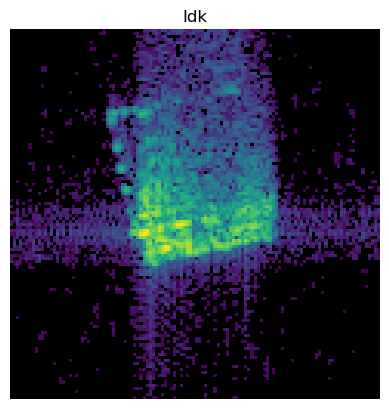

In [49]:
# Training Setup
center_crop = transforms.CenterCrop(size=(120, 120)) # 250 x 170 optimal, but paper uses 120 x 120

dataset = ISARDataset('test/test_labels.csv', r'test/data', transform=center_crop)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=3, shuffle=False)

model = SAISARNet(num_classes=4)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], int(label_batch[0])

# Fix colormap (scuffed)
colors = plt.cm.viridis(np.linspace(0, 1, 256))  # Get colors from viridis
colors[0] = [0, 0, 0, 1]                       # Set first color to blackhow print(cmap[0])
cmap = ListedColormap(colors)  # Normalize colors to [0, 1]

# Display first image
plt.imshow(image.permute(1, 2, 0), cmap=cmap)
plt.title(class_names[label])
plt.axis('off')

# Testing sizes
print(image_batch.shape)
print(model(image_batch).shape)
print(f'Lower ConvNet: {model.lower_convnet(image_batch).shape}')
# print(f'Deformed affine ConvNet: {model.deform_affine(image_batch).shape}')
print(f'Deformed shrink ConvNet: {model.deform_shrink(image_batch).shape}')

# # Training Loop (Conceptual)
# for epoch in range(num_epochs):
#     for images, labels in train_loader:
#         # ... training logic (zero gradients, forward pass, loss calculation, backward pass, optimization step)

# # Evaluation Loop (Conceptual)
# with torch.no_grad():
#     for images, labels in test_loader:
#         # ... evaluation logic (model prediction, accuracy calculation)


In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm  # Progress bar (optional, but highly recommended)

num_classes = 4

# Training Setup
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
model = SAISARNet(num_classes=num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
num_epochs = 10  # Set the desired number of epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")  # Progress bar

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients from the previous iteration
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()         # Backpropagation to calculate gradients
        optimizer.step()        # Update model parameters

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar with loss and accuracy
        progress_bar.set_postfix({'loss': loss.item(), 'accuracy': 100 * correct / total})

    train_loss /= len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f} Train Acc: {100 * correct / total:.2f}%")

# Save the Model (Optional)
torch.save(model.state_dict(), "saisar_net_model.pth")


Epoch 1/10:   0%|          | 0/1 [00:00<?, ?it/s]

hi
hi


RuntimeError: Given groups=1, weight of size [8, 1, 3, 3], expected input[1, 29, 9, 9] to have 1 channels, but got 29 channels instead

In [ ]:
import torch
import torch.nn as nn
from torchvision.ops import DeformConv2d  # Install torchvision if not already installed

class SAISARNet(nn.Module):
    def __init__(self, num_classes):
        super(SAISARNet, self).__init__()

        # Global Image Adjustment
        self.global_conv = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),  # Input channels: 1 (grayscale)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            DeformConv2d(8, 16, kernel_size=3, padding=1),  # Deformable convolution
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Local Image Adjustment
        self.local_conv = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            DeformConv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Bi-LSTM and Attention
        self.bilstm = nn.LSTM(input_size=16 * 14 * 14, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)
        self.attention = nn.Sequential(
            nn.Linear(256, 1),  # Two directions * hidden_size
            nn.Tanh()
        )
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        global_features = self.global_conv(x)  # (batch_size, 16, 14, 14)
        local_features = self.local_conv(x)   # (batch_size, 16, 14, 14)

        # Combine global and local features (choose one method)
        # Method 1: Concatenate along channel dimension
        # combined_features = torch.cat((global_features, local_features), dim=1)  # (batch_size, 32, 14, 14)

        # Method 2: Add the features
        combined_features = global_features + local_features

        # Flatten for LSTM input
        combined_features = combined_features.view(combined_features.size(0), -1, combined_features.size(1))

        # Bi-LSTM
        lstm_out, _ = self.bilstm(combined_features)

        # Attention
        attention_weights = self.attention(lstm_out)
        attention_weights = torch.softmax(attention_weights, dim=1)  # Normalize attention weights
        weighted_lstm_out = torch.sum(lstm_out * attention_weights, dim=1)

        # Classification
        output = self.classifier(weighted_lstm_out)
        return output
